# COMP90084 Workshop Week 7
In this week's workshop, we'll program the algorithms we encountered during the lectures last week.

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
import qiskit as qk
from qiskit.circuit import Gate
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plt
from qiskit.quantum_info import partial_trace, DensityMatrix, Statevector
%matplotlib inline
# shots simulation
backend_sim = Aer.get_backend('qasm_simulator')
# statevector
backend_sv = Aer.get_backend('statevector_simulator')


Q1

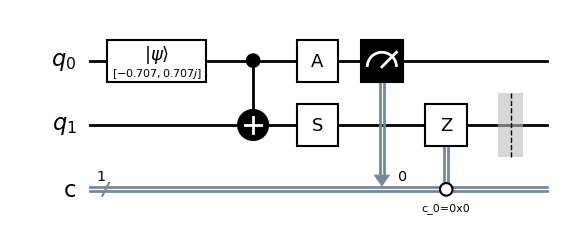

State observed q1:
 [[0.5       +0.j         0.35355339-0.35355339j]
 [0.35355339+0.35355339j 0.5       +0.j        ]]
State expected q1:
 [[0.5       +0.j         0.35355339+0.35355339j]
 [0.35355339-0.35355339j 0.5       +0.j        ]]


In [75]:
from math import sqrt
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.states import Statevector
import math
alpha = complex(0.24506488, 0.9633)
beta = complex(0.0046248, 0.10943)



def Q1(a, b):
    qc = QuantumCircuit(2, 1)
    qc.initialize([a,b], 0)
    qc.cx(0,1)
    qc.s(1)
    sqrt_2_half = math.sqrt(2)/2
    recp_sqrt_2 = 1/math.sqrt(2)
    # qc.barrier()
    cx = Operator([
        [recp_sqrt_2, -recp_sqrt_2*complex(sqrt_2_half, sqrt_2_half)],
        [recp_sqrt_2, recp_sqrt_2*complex(sqrt_2_half, sqrt_2_half)],
    ])
    qc.unitary(cx, 0, label='A')
    qc.measure(0,0)
    qc.z(1).c_if(0, 0)
    qc.snapshot(label="Bob_State", qubits=[1])
    
    
    
    return qc

# qc = Q1(sqrt(2)/2, sqrt(2)/2)
# a = 0
# b = 1
a=-1/np.sqrt(2)
b=1j/np.sqrt(2)
qc = Q1(a, b)
display(qc.draw('mpl', style = "bw"))

job = backend_sv.run(transpile(qc, backend_sv), shots=1)
result = job.result()


state = partial_trace(result.get_statevector(), [0]) # snapshot in qiskit keeps all the qubits, need to trace out the measured ones
print("State observed q1:\n",np.real_if_close(state.data))

sqrt_2_half = math.sqrt(2)/2
T = np.array([
    [1, 0], 
    [0, complex(sqrt_2_half, sqrt_2_half)]])

T_psi = T.dot([a, b])
print("State expected q1:\n",np.real_if_close(DensityMatrix(Statevector(T_psi)).data))


{'01': 1022, '00': 1026}
Classical information sent by Alice: dict_keys(['01', '00'])
State recieved by Bob:
 [[1.]]


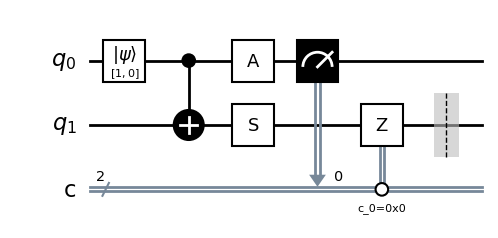

In [44]:

job = backend_sv.run(transpile(qc, backend_sv), shots=1)
result = job.result()
counts = result.get_counts(qc)
print(counts)
print("Classical information sent by Alice:", counts.keys())
bob_state = partial_trace(result.get_statevector(), [0,1]) # snapshot in qiskit keeps all the qubits, need to trace out the measured ones
print("State recieved by Bob:\n",np.real_if_close(bob_state.data))
qc.draw('mpl',style="bw", scale = 1)

Q1.2

Q1.2.a

This problem can be solved in 1 query with the Deutsh Jozsa Algorithmn.
The algorithmn works by feeding in qubits in a superposition into the function, and conditionally apply it second quibit also in the superposition state.
This hamard n gate acts to sum all this qbits
After passing through the function, they are summation of (-1)^f(xi)
Apply another Hammard gate but only inspect the |0> state, which is dependent upon f(x).
The sum is either constant for -1 or +1, else if balance it is 0.


-----------------------------------------------------


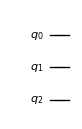

{'00': 2048}
constant


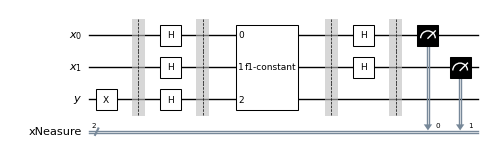

-----------------------------------------------------


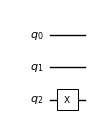

{'00': 2048}
constant


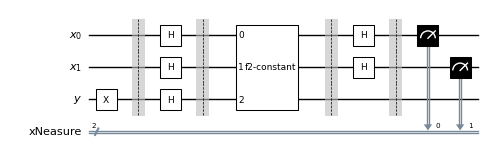

-----------------------------------------------------


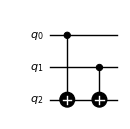

{'11': 2048}
balanced


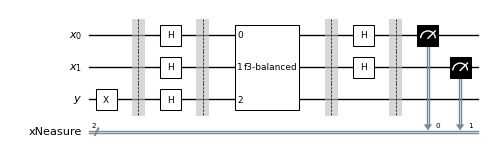

-----------------------------------------------------


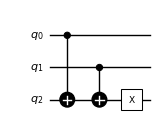

{'11': 2048}
balanced


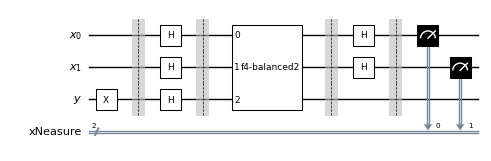

In [106]:
def f1():
    qc = QuantumCircuit(3, name="f1-constant")
    return qc

def f2():
    qc = QuantumCircuit(3, name="f2-constant")
    qc.x(2)
    return qc


def f3():
    qc = QuantumCircuit(3, name="f3-balanced")
    qc.cx(0, 2)
    qc.cx(1, 2)
    return qc

def f4():
    qc = QuantumCircuit(3, name="f4-balanced2")
    qc.cx(0, 2)
    qc.cx(1, 2)
    qc.x(2)
    return qc

# define the Deutsch-Jozsa function
def deutsch_josza(function=None, num_qubits = 2):
    x = QuantumRegister(num_qubits-1, "x")
    y = QuantumRegister(1, "y")
    cr = ClassicalRegister(num_qubits-1, "xNeasure")

    qc = QuantumCircuit(x, y, cr)
    # X gate on the function output qubit
    qc.x(y)
    qc.barrier()
    # H gate everywhere
    qc.h([*x, *y])
    qc.barrier()
    # append the function
    if function is None:
        f = Gate(name='Uf', num_qubits=num_qubits, params=[])
        qc.append(f, list(range(num_qubits)))
        qc.barrier()
    else:
        f = function.to_instruction()
        qc.append(f, list(range(num_qubits)))
        qc.barrier()
    qc.h(x)
    qc.barrier()
    qc.measure(x, cr)
    return qc

def print_is_balanced_or_constant(Uf, num_qubits):
    print("-----------------------------------------------------")
    display(Uf.draw('mpl',style="bw", scale = 0.5))
    dj_1_qubit = deutsch_josza(Uf, num_qubits)
    job_dj_1_qubit = backend_sim.run(transpile(dj_1_qubit, backend_sim), shots=2048)
    result_dj_1_qubit = job_dj_1_qubit.result()
    counts_dj_1_qubit = result_dj_1_qubit.get_counts(dj_1_qubit)
    print(counts_dj_1_qubit)

    max_key = ""
    max_count = 0
    for key in counts_dj_1_qubit:
        count = counts_dj_1_qubit[key]
        if(count > max_count):
            max_count = count
            max_key = key
    
    #if only zeros, then it is constant, else balanaced
    if(max_key.find("1") == -1):
        print("constant")
    else:
        print("balanced")
    
    display(dj_1_qubit.draw('mpl',style="bw", scale = 0.5))
    



print_is_balanced_or_constant(f1(), 3)

print_is_balanced_or_constant(f2(), 3)

print_is_balanced_or_constant(f3(), 3)

print_is_balanced_or_constant(f4(), 3)

Q1.2.2

In [107]:
def f1():
    qc = QuantumCircuit(4, name="f1-constant")
    return qc

def f2():
    qc = QuantumCircuit(4, name="f2-constant")
    qc.x(3)
    return qc


def f3():
    qc = QuantumCircuit(4, name="f3-balanced")
    qc.cx(0, 3)
    qc.cx(1, 3)
    return qc

def f4():
    qc = QuantumCircuit(4, name="f3-balanced")
    qc.cx(0, 3)
    qc.cx(1, 3)
    qc.x(3)
    return qc

def calc_answer(circuit, i, j, k, showExample):
    num_qubits = 4

    num_c_bits = 1
    qr = QuantumRegister(num_qubits, "x and y")
    if(showExample):
        cr1 = ClassicalRegister(num_qubits, "state0")
        cr2 = ClassicalRegister(num_qubits, "state1")
        cr3 = ClassicalRegister(num_qubits, "state3")

        qc = QuantumCircuit(qr, cr1, cr2, cr3)

        qc.measure(qr, cr1)
        qc.barrier()

    else:
        cr3 = ClassicalRegister(1, "out")
        qc = QuantumCircuit(qr, cr3)

    if(i == 1):
        qc.x(0)
    if(j == 1):
        qc.x(1)
    if(k == 1):
        qc.x(2)

    qc.barrier()
    
    
    if(showExample):
        qc.measure(qr, cr2)
        qc.barrier()

    f = circuit.to_instruction()
    qc.append(f, list(range(num_qubits)))
    qc.barrier()

    if(showExample):
        qc.measure(qr, cr3)
    else:
        qc.measure(3, 0)


    job = backend_sim.run(transpile(qc, backend_sim), shots=2048)
    result_dj_1_qubit = job.result()
    counts_dj_1_qubit = result_dj_1_qubit.get_counts(qc)
    if(showExample):
        display(qc.draw('mpl',style="bw", scale = 0.5))
    
    max_key = ""
    max_count = 0
    for key in counts_dj_1_qubit:
        count = counts_dj_1_qubit[key]
        if(count > max_count):
            max_count = count
            max_key = key

    max_key = max_key[::-1]

    if(showExample):
        splits = max_key.split(" ")
        return {"state1: " : splits[0], "state2: " : splits[1], "state3: " : splits[2]}
    else:
        return max_key

def proof_of_work(circuit):
    
    results = {}

    for i in range(2):
        for j in range(2):
            for k in range(2):
                results[str(i)+str(j)+str(k)] = calc_answer(circuit, i, j, k, False)

    print(circuit.name, end =": ")
    print(results)






In [108]:
proof_of_work(f1())
proof_of_work(f2())
proof_of_work(f3())
proof_of_work(f4())

f1-constant: {'000': '0', '001': '0', '010': '0', '011': '0', '100': '0', '101': '0', '110': '0', '111': '0'}
f2-constant: {'000': '1', '001': '1', '010': '1', '011': '1', '100': '1', '101': '1', '110': '1', '111': '1'}
f3-balanced: {'000': '0', '001': '0', '010': '1', '011': '1', '100': '1', '101': '1', '110': '0', '111': '0'}
f3-balanced: {'000': '1', '001': '1', '010': '0', '011': '0', '100': '0', '101': '0', '110': '1', '111': '1'}


-----------------------------------------------------


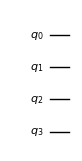

{'000': 2048}
constant


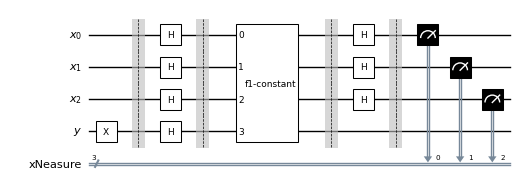

-----------------------------------------------------


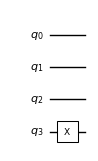

{'000': 2048}
constant


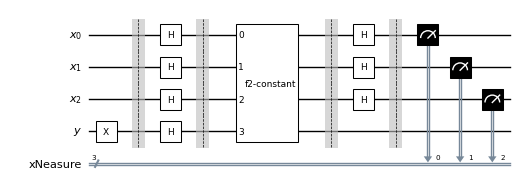

-----------------------------------------------------


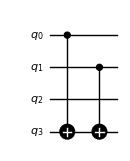

{'011': 2048}
balanced


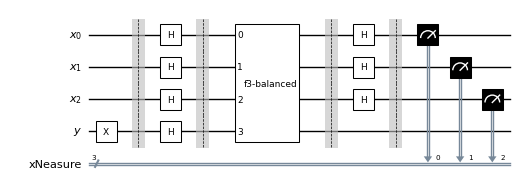

-----------------------------------------------------


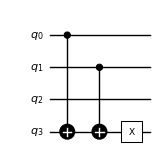

{'011': 2048}
balanced


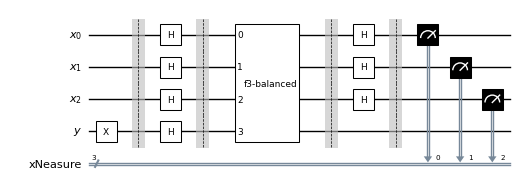

In [109]:
print_is_balanced_or_constant(f1(), 4)
print_is_balanced_or_constant(f2(), 4)
print_is_balanced_or_constant(f3(), 4)
print_is_balanced_or_constant(f4(), 4)

f1: 

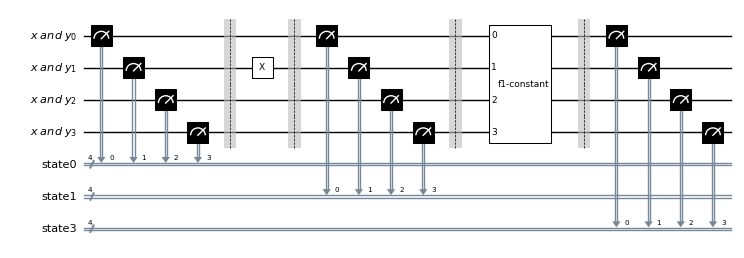

{'state1: ': '0000', 'state2: ': '0100', 'state3: ': '0100'}
f2: 

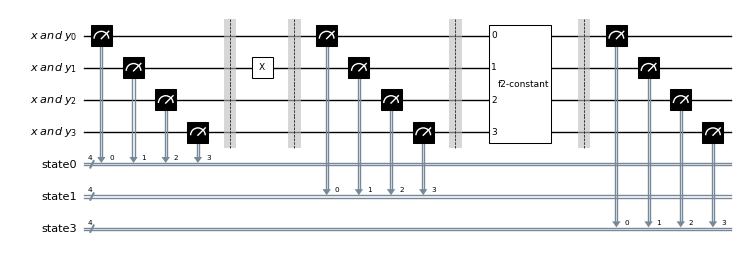

{'state1: ': '0000', 'state2: ': '0100', 'state3: ': '0101'}
f3: 

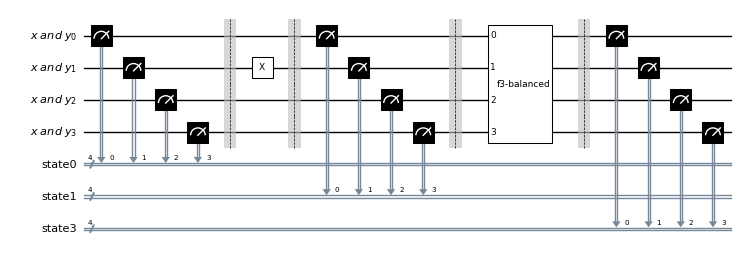

{'state1: ': '0000', 'state2: ': '0100', 'state3: ': '0101'}
f4: 

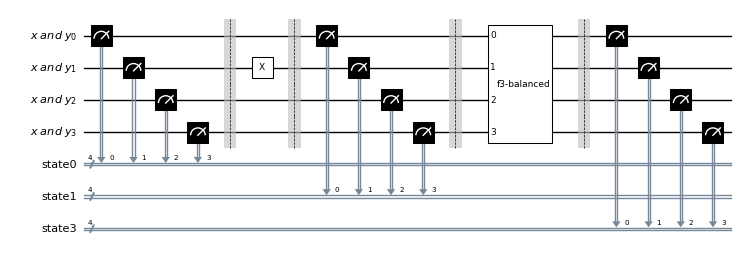

{'state1: ': '0000', 'state2: ': '0100', 'state3: ': '0100'}


In [110]:
#bit 1 is the left most bit
bit1 = 0
bit2 = 1
bit3 = 0

print("f1: ", end="")
print(calc_answer(f1(), bit1, bit2, bit3, True))

print("f2: ", end="")
print(calc_answer(f2(), bit1, bit2, bit3, True))

print("f3: ", end="")
print(calc_answer(f3(), bit1, bit2, bit3, True))

print("f4: ", end="")
print(calc_answer(f4(), bit1, bit2, bit3, True))

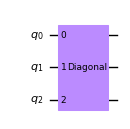

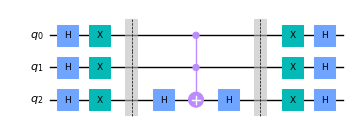

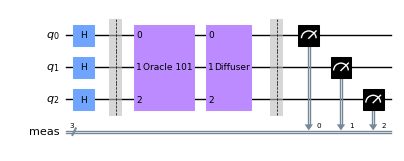

{'010': 3, '110': 3, '101': 77, '001': 3, '000': 1, '011': 5, '111': 2, '100': 6}


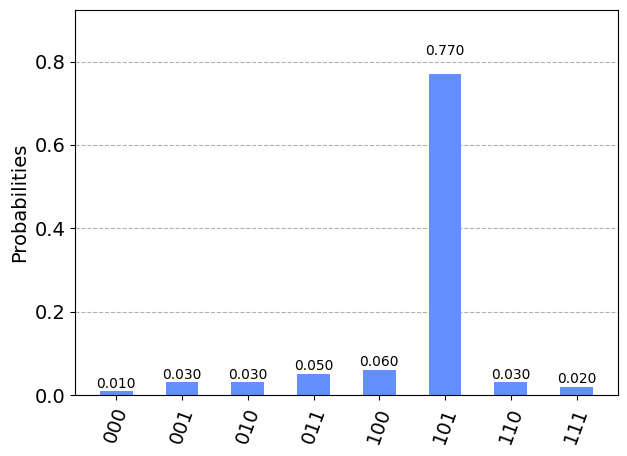

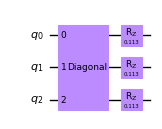

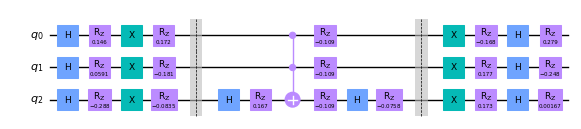

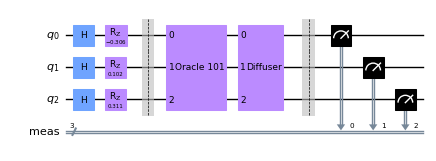

{'101': 66, '110': 5, '001': 7, '010': 3, '100': 9, '111': 8, '000': 1, '011': 1}


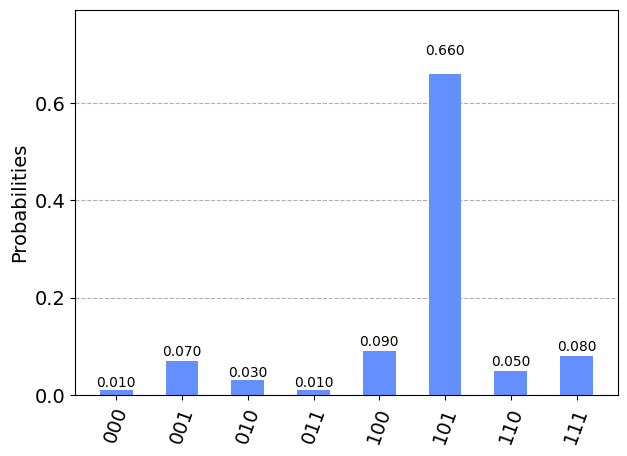

In [247]:


from qiskit_textbook.problems import grover_problem_oracle

from qiskit.circuit.library import Diagonal
import random
from math import pi

error_level = 0 #pi * 0.1


def error(circuit, reg):
    global error_level
    if(error_level == 0):
        return
    err = (random.random()*2-1) * error_level
    circuit.rz(err, reg)


def oracle():
    oracle = Diagonal([1, 1, 1, 1, 1, -1, 1, 1])
    oracle.name = "Oracle 101"
    error(oracle, [0,1,2])
    return oracle


# created a general diffuser
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits, name="Diffuser")
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
        error(qc, qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
        error(qc, qubit)

    # Do multi-controlled-Z gate
    qc.barrier()
    qc.h(nqubits-1)
    error(qc, nqubits-1)

    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    error(qc, list(range(nqubits)))
    
    qc.h(nqubits-1)
    error(qc, nqubits-1)
    qc.barrier()
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
        error(qc, qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
        error(qc, qubit)

    return qc


def grov():
    n = 3
    diffu = diffuser(n).to_instruction()
    diffu.name = 'Diffuser'

    orc = oracle().to_instruction()

    grover_circuit = QuantumCircuit(n, name="Grover")

    for i in range(n):
        grover_circuit.h(i)
        error(grover_circuit, i)

    grover_circuit.barrier()
    grover_circuit.append(orc, [0,1,2])
    grover_circuit.append(diffu, [0,1,2])

    grover_circuit.measure_all()

    return grover_circuit




def run_grover():
    total_counts = {}
    for i in range(100):
        grover_circuit = grov()

        job = backend_sim.run(transpile(grover_circuit, backend_sim), shots=1)
        counts_1 = job.result().get_counts(grover_circuit)

        for key in counts_1:
            if key in total_counts:
                total_counts[key] += counts_1[key]
            else:
                total_counts[key] = counts_1[key]


    print(total_counts)
    display(plot_histogram(total_counts))


error_level = 0
display(oracle().draw('mpl', scale=0.5))
display(diffuser(3).draw('mpl', scale=0.5))
display(grov().draw('mpl', scale=0.5))
run_grover()


error_level = 0.1 * pi
display(oracle().draw('mpl', scale=0.5))
display(diffuser(3).draw('mpl', scale=0.5))
display(grov().draw('mpl', scale=0.5))
run_grover()




Q2

In [263]:
#Q2a
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()

cov = np.cov(iris.data.T)

print("Covariance matrix is \n", cov)
print()

p = cov / np.trace(cov)

print("P is \n", p)
print()


Covariance matrix is 
 [[ 0.68569351 -0.042434    1.27431544  0.51627069]
 [-0.042434    0.18997942 -0.32965638 -0.12163937]
 [ 1.27431544 -0.32965638  3.11627785  1.2956094 ]
 [ 0.51627069 -0.12163937  1.2956094   0.58100626]]

P is 
 [[ 0.14994532 -0.00927934  0.27866333  0.11289647]
 [-0.00927934  0.04154411 -0.07208823 -0.02659972]
 [ 0.27866333 -0.07208823  0.68145793  0.28331983]
 [ 0.11289647 -0.02659972  0.28331983  0.12705264]]

